# Denoising by proximal solvers - as in Chambolle paper

We try to solve the following problem (as in Pock and Chambolle paper):

$$
arg \;  min_\mathbf{u} \frac{\lambda}{2}||\mathbf{u-f}||_2^2 + J(\mathbf{u})
$$

with different choices of regularization:

- L2 on Gradient $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_2^2$
- Anisotropic TV $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_1$
- Anisotropic TV + Bregman iterations $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_1 - \mathbf{p}_k^T \mathbf{u}$
- Isotropic TV $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_{2,1}$
- Isotropic TV + Bregman iterations $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_{2,1} - \mathbf{p}_k^T \mathbf{u}$

Finally we compare the convergence properties of the Primal-Dual algorithm with the adaptive Primal-Dual algorithm of Goldstein - we can see how the latter converges faster to the solution

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from skimage.data import camera
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *

np.random.seed(0)

In [2]:
def callback(x):
    mhist.append(x)

Data and operators preparation

In [3]:
# Load image
img = camera()
ny, nx = img.shape

# Add noise
sigman = 30
n = np.random.normal(0, sigman, img.shape)
noise_img = img + n

#img = img/255
#noise_img = noise_img/255

In [4]:
# Gradient operator
sampling = 1.
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')

### L2 on Gradient

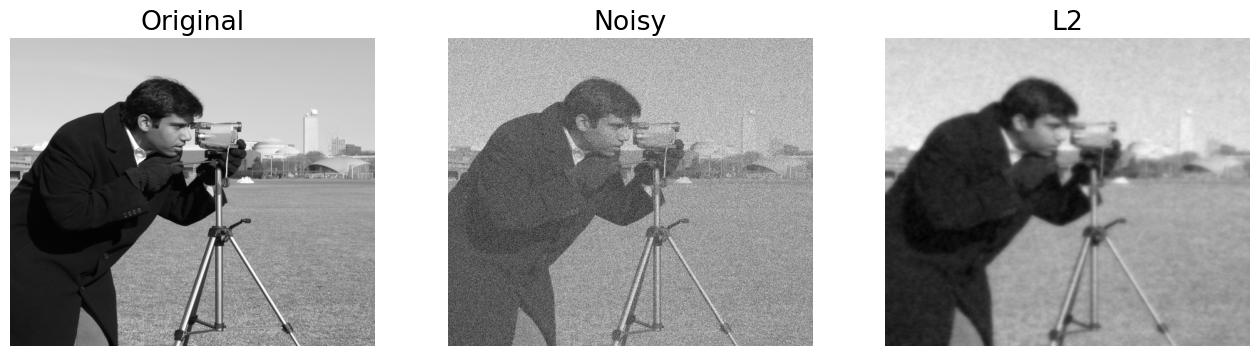

In [5]:
# L2 data term
lamda = .1
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# L2 regularization
thik = L2()

L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1.
mu = 1. / (tau*L)

iml2 = LinearizedADMM(l2, thik, Gop, tau=tau, mu=mu, x0=np.zeros_like(img.ravel()), 
                      niter=100)[0]
iml2 = iml2.reshape(img.shape)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(noise_img, cmap='gray')
axs[1].set_title('Noisy')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(iml2, cmap='gray')
axs[2].set_title('L2')
axs[2].axis('off')
axs[2].axis('tight');

### Anisotropic TV

In [6]:
# L2 data term
lamda = 0.01
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# Anisotropic TV
l1 = L1()

L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = 10. / np.sqrt(L)
mu = tau / L

iml1 = LinearizedADMM(l2, l1, Gop, tau=tau, mu=mu, 
                      x0=np.zeros_like(img.ravel()), 
                      niter=100)[0]
iml1 = iml1.reshape(img.shape)

### Anisotropic TV + Bregman iterations

In [7]:
# L2 data term
lamda = .001
l2 = L2(b=noise_img.ravel(), sigma=lamda, qgrad=False)

# Anisotropic TV
l1 = L1()

L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = 10. / np.sqrt(L)
mu = tau / L

iml1b = Bregman(l2, l1, A=Gop, x0=np.zeros_like(img.ravel()), 
                solver=LinearizedADMM, niterouter=10, show=True,
                **dict(tau=tau, mu=mu, niter=50))
iml1b = iml1b.reshape(img.shape)

Bregman
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.gradient.Gradient'>
Inner Solver: <function LinearizedADMM at 0x300b35620>
alpha = 1.000000e+00	tolf = 1.000000e-10	tolx = 1.000000e-10
niter = 10

   Itn       x[0]          f           g       J = f + g
     1   4.40756e+00   2.892e+06   7.043e+03   2.899e+06
     2   8.71946e+00   2.776e+06   1.449e+04   2.790e+06
     3   1.29378e+01   2.663e+06   2.262e+04   2.686e+06
     4   1.70646e+01   2.555e+06   3.138e+04   2.586e+06
     5   2.11019e+01   2.451e+06   4.085e+04   2.492e+06
     6   2.50516e+01   2.352e+06   5.095e+04   2.403e+06
     7   2.89157e+01   2.256e+06   6.188e+04   2.318e+06
     8   3.26960e+01   2.165e+06   7.378e+04   2.239e+06
     9   3.63943e+01   2.077e+06   8.633e+04   2.164e+06
    10   4.00126e+01   1.993e+06   9.949e+04   

### Isotropic TV with Primal-Dual

In [8]:
# L2 data term
lamda = .01
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# L1 regularization (isotropic TV)
l1iso = L21(ndim=2)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1 / np.sqrt(L)
mu = 1. / (tau*L)

iml12 = PrimalDual(l2, l1iso, Gop, tau=tau, mu=mu, theta=1., 
                   x0=np.zeros_like(img.ravel()), 
                   niter=100, show=True)
iml12 = iml12.reshape(img.shape)

iml12_1 = PrimalDual(l2, l1iso, Gop, tau=tau, mu=mu, theta=1., 
                     x0=np.zeros_like(img.ravel()), gfirst=False,
                     niter=100, show=True)
iml12_1 = iml12_1.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.gradient.Gradient'>
Additional vector (z): None
tau = 0.35355339059327373		mu = 0.3535533905932738
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   8.91062e-01   2.991e+07   5.056e+04   0.000e+00       2.996e+07
     2   1.66155e+00   2.971e+07   4.671e+04   0.000e+00       2.976e+07
     3   2.34475e+00   2.952e+07   3.774e+04   0.000e+00       2.955e+07
     4   2.98229e+00   2.932e+07   3.237e+04   0.000e+00       2.935e+07
     5   3.60652e+00   2.913e+07   3.064e+04   0.000e+00       2.916e+07
     6   4.23765e+00   2.893e+07   2.991e+04   0.000e+00       2.896e+07
     7   4.88476e+00   2.874e+07   2.936e+04   0.000e+00       2.877e+07
     8   5.54889e+

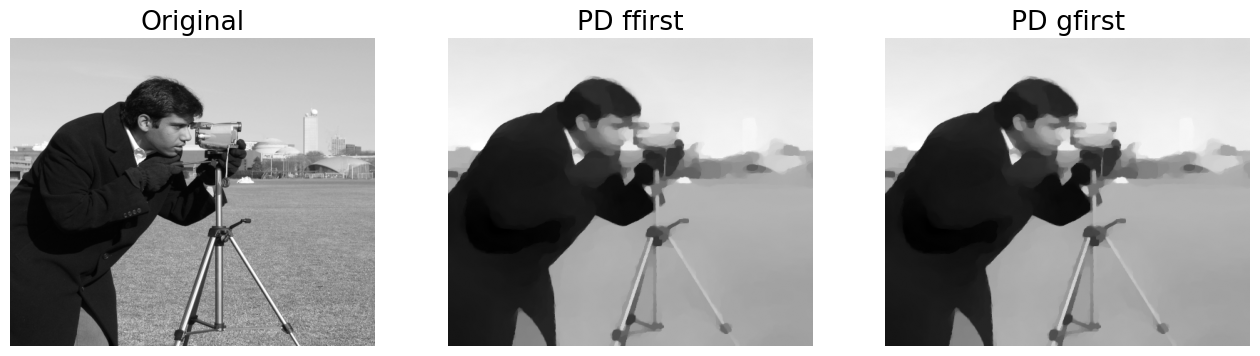

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(iml12, cmap='gray')
axs[1].set_title('PD ffirst')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(iml12_1, cmap='gray')
axs[2].set_title('PD gfirst')
axs[2].axis('off')
axs[2].axis('tight');

### Isotropic TV + Bregman iterations

In [10]:
lamda = 0.001
l2 = L2(b=noise_img.ravel(), sigma=lamda, qgrad=False)

# L1 regularization (isotropic TV)
l1iso = L21(ndim=2)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
#tau = 0.01
tau = 1 / np.sqrt(L)
mu = 1. / (tau*L)

iml12b = Bregman(l2, l1iso, A=Gop, x0=np.zeros_like(img.ravel()), 
                 solver=PrimalDual, niterouter=10, show=True,
                 **dict(tau=tau, mu=mu, theta=1., niter=50))
iml12b = iml12b.reshape(img.shape)

Bregman
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.gradient.Gradient'>
Inner Solver: <function PrimalDual at 0x300b35940>
alpha = 1.000000e+00	tolf = 1.000000e-10	tolx = 1.000000e-10
niter = 10

   Itn       x[0]          f           g       J = f + g
     1   3.53398e+00   2.916e+06   4.452e+03   2.920e+06
     2   7.00645e+00   2.821e+06   9.371e+03   2.830e+06
     3   1.04185e+01   2.729e+06   1.483e+04   2.744e+06
     4   1.37712e+01   2.640e+06   2.090e+04   2.660e+06
     5   1.70656e+01   2.553e+06   2.755e+04   2.581e+06
     6   2.03026e+01   2.469e+06   3.490e+04   2.504e+06
     7   2.34834e+01   2.389e+06   4.304e+04   2.432e+06
     8   2.66089e+01   2.310e+06   5.186e+04   2.362e+06
     9   2.96800e+01   2.235e+06   6.124e+04   2.296e+06
    10   3.26978e+01   2.162e+06   7.104e+04   2.

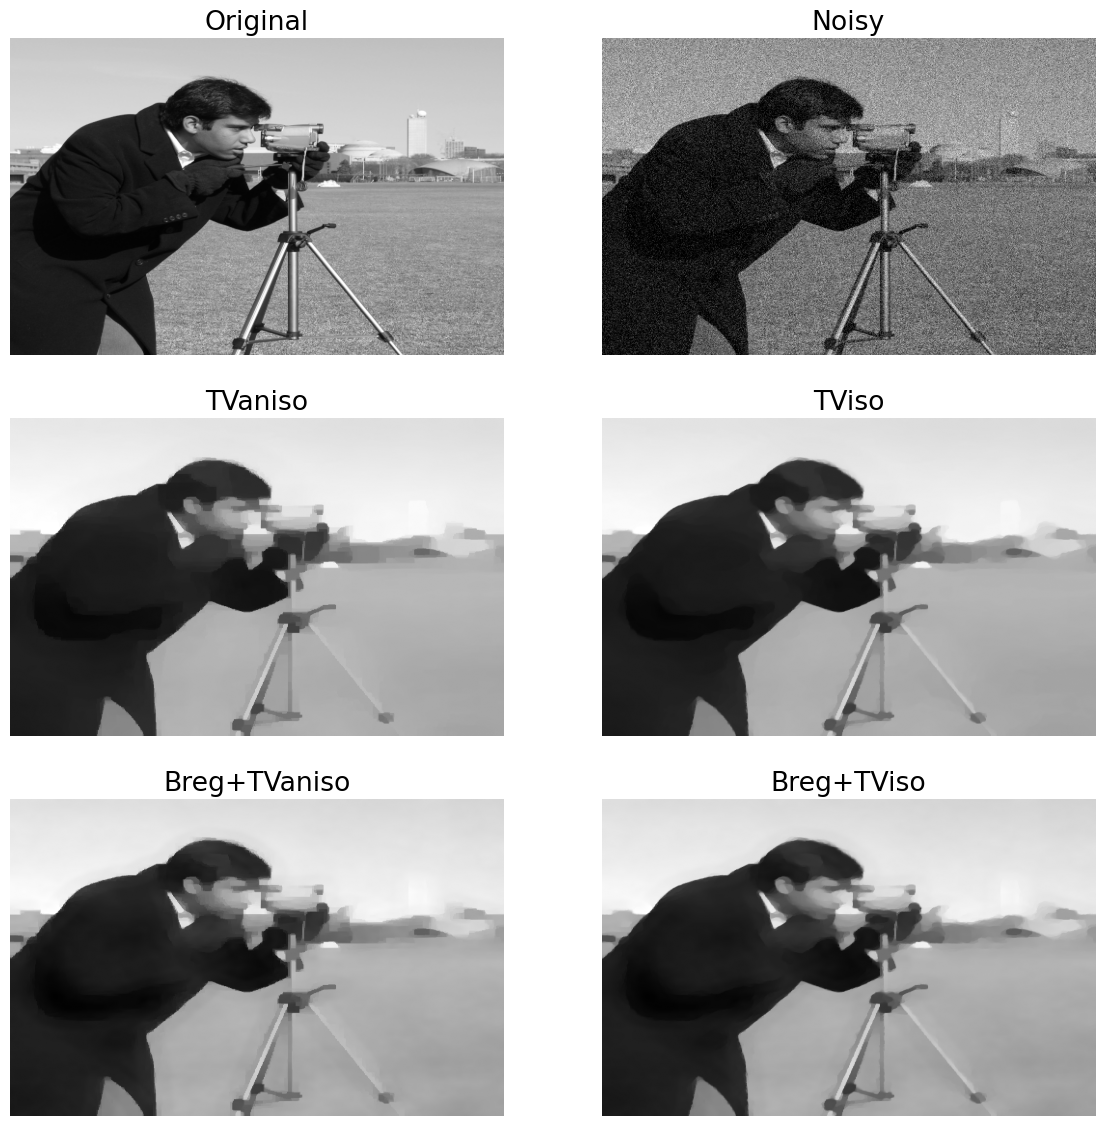

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(14, 14))
axs[0][0].imshow(img/img.max(), cmap='gray', vmin=0, vmax=1)
axs[0][0].set_title('Original')
axs[0][0].axis('off')
axs[0][0].axis('tight')
axs[0][1].imshow(noise_img/noise_img.max(), cmap='gray', vmin=0, vmax=1)
axs[0][1].set_title('Noisy')
axs[0][1].axis('off')
axs[0][1].axis('tight')
axs[1][0].imshow(iml1/iml1.max(), cmap='gray', vmin=0, vmax=1)
axs[1][0].set_title('TVaniso')
axs[1][0].axis('off')
axs[1][0].axis('tight')
axs[1][1].imshow(iml12/iml12.max(), cmap='gray', vmin=0, vmax=1)
axs[1][1].set_title('TViso')
axs[1][1].axis('off')
axs[1][1].axis('tight');
axs[2][0].imshow(iml1b/iml1b.max(), cmap='gray', vmin=0, vmax=1)
axs[2][0].set_title('Breg+TVaniso')
axs[2][0].axis('off')
axs[2][0].axis('tight')
axs[2][1].imshow(iml12b/iml12b.max(), cmap='gray', vmin=0, vmax=1)
axs[2][1].set_title('Breg+TViso')
axs[2][1].axis('off')
axs[2][1].axis('tight');

## Adaptive PD

In [12]:
def callback(x, f, g, K, cost):
    cost.append(f(x) + g(K.matvec(x)))

In [13]:
# Load image
img = camera()
ny, nx = img.shape

# Add noise
sigman = 20
n = np.random.normal(0, sigman, img.shape)
noise_img = img + n

In [14]:
# L2 data term
lamda = .04
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# L1 regularization (isotropic TV)
l1iso = L21(ndim=2)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
tau = 0.95 / np.sqrt(L)
mu = 0.95 / np.sqrt(L)

cost_fixed = []
iml12_fixed = PrimalDual(l2, l1iso, Gop, tau=tau, mu=mu, theta=1., 
                         x0=np.zeros_like(img.ravel()), gfirst=False,
                         niter=300, show=True, callback=lambda x: callback(x, l2, l1iso, Gop, cost_fixed))
iml12_fixed = iml12_fixed.reshape(img.shape)

cost_ada = []
iml12_ada, steps = AdaptivePrimalDual(l2, l1iso, Gop, tau=tau, mu=mu,
                                      x0=np.zeros_like(img.ravel()), niter=45, show=True, tol=0.05,
                                      callback=lambda x: callback(x, l2, l1iso, Gop, cost_ada))
iml12_ada = iml12_ada.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.gradient.Gradient'>
Additional vector (z): None
tau = 0.33587572106361		mu = 0.33587572106361
theta = 1.00		niter = 300

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   2.55233e+00   1.149e+08   1.330e+05   0.000e+00       1.150e+08
     2   5.17823e+00   1.119e+08   1.385e+05   0.000e+00       1.120e+08
     3   7.82271e+00   1.090e+08   1.220e+05   0.000e+00       1.092e+08
     4   1.04172e+01   1.063e+08   1.119e+05   0.000e+00       1.064e+08
     5   1.29162e+01   1.035e+08   1.111e+05   0.000e+00       1.036e+08
     6   1.53085e+01   1.009e+08   1.145e+05   0.000e+00       1.010e+08
     7   1.76128e+01   9.830e+07   1.189e+05   0.000e+00       9.842e+07
     8   1.98587e+01   

In [15]:
# Error norm comparision
print(np.linalg.norm(img.ravel()-iml12_fixed.ravel()), np.linalg.norm(img.ravel()-iml12_ada.ravel()))

5045.012817086085 5033.730231638987


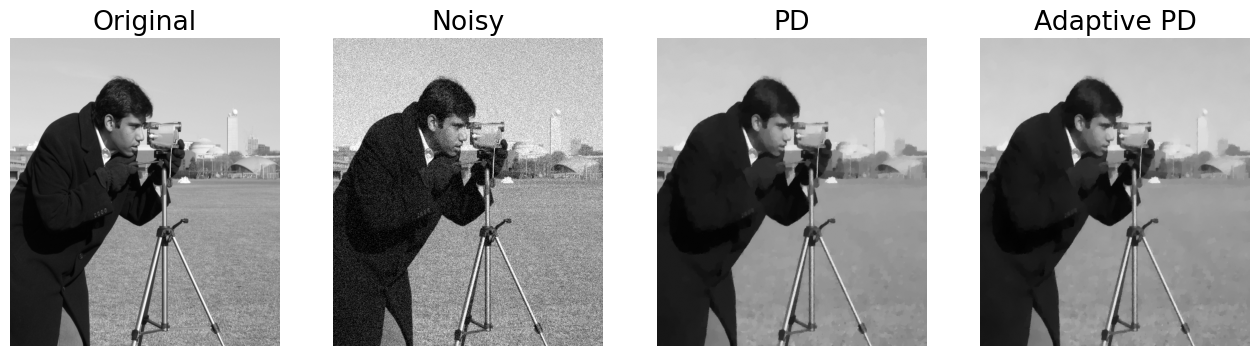

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(noise_img, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Noisy')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(iml12_fixed, cmap='gray', vmin=0, vmax=255)
axs[2].set_title('PD')
axs[2].axis('off')
axs[2].axis('tight')
axs[3].imshow(iml12_ada, cmap='gray', vmin=0, vmax=255)
axs[3].set_title('Adaptive PD')
axs[3].axis('off')
axs[3].axis('tight');

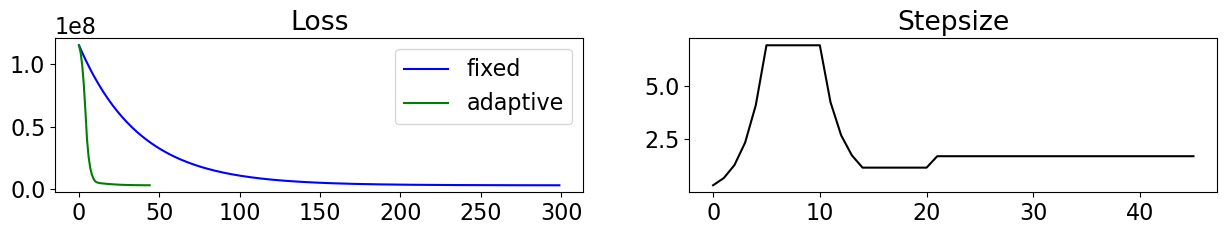

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 2))
axs[0].plot(cost_fixed, 'b', label='fixed')
axs[0].plot(cost_ada, 'g', label='adaptive')
axs[0].set_title('Loss')
axs[0].legend()

axs[1].plot(steps[0], 'k')
axs[1].set_title('Stepsize');